# visualization

## import 

In [63]:
from __future__ import print_function
import sys
from syslog import LOG_MAIL

from urllib3 import Retry
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import random
import os
import argparse
import numpy as np
from PreResNet_cifar import *
import dataloader_cifar as dataloader
from math import log2
from Contrastive_loss import *

import collections.abc
from collections.abc import MutableMapping
from flow_trainer import FlowTrainer
from flowModule.utils import standard_normal_logprob

model_name_1 = 'Net1_warmup.pth'
model_name_2 = 'Net2_warmup.pth'

model_name_flow_1 = 'FlowNet1_warmup.pth'
model_name_flow_2 = 'FlowNet2_warmup.pth'
project_path = './checkpoint/cifar10_sym_0.5_flow_testV1'
isFlow = True
num_samples = 50000


In [64]:
parser = argparse.ArgumentParser(description='PyTorch CIFAR Training')
parser.add_argument('--batch_size', default=64, type=int, help='train batchsize') 
parser.add_argument('--lr', '--learning_rate', default=0.02, type=float, help='initial learning rate')
parser.add_argument('--noise_mode',  default='sym')
parser.add_argument('--alpha', default=4, type=float, help='parameter for Beta')
parser.add_argument('--lambda_u', default=30, type=float, help='weight for unsupervised loss')
parser.add_argument('--lambda_c', default=0.025, type=float, help='weight for contrastive loss')
parser.add_argument('--T', default=0.5, type=float, help='sharpening temperature')
parser.add_argument('--num_epochs', default=350, type=int)
parser.add_argument('--r', default=0.5, type=float, help='noise ratio')
parser.add_argument('--d_u',  default=0.7, type=float)
parser.add_argument('--tau', default=5, type=float, help='filtering coefficient')
parser.add_argument('--metric', type=str, default = 'JSD', help='Comparison Metric')
parser.add_argument('--seed', default=123)
parser.add_argument('--gpuid', default=0, type=int)
parser.add_argument('--resume', default=False, type=bool, help = 'Resume from the warmup checkpoint')
parser.add_argument('--num_class', default=10, type=int)
parser.add_argument('--data_path', default='./data/cifar10', type=str, help='path to dataset')
parser.add_argument('--dataset', default='cifar10', type=str)
parser.add_argument('--flow_modules', default="8-8-8-8", type=str)
parser.add_argument('--name', default="", type=str)
args = parser.parse_args(args=[])

print(args)

Namespace(T=0.5, alpha=4, batch_size=64, d_u=0.7, data_path='./data/cifar10', dataset='cifar10', flow_modules='8-8-8-8', gpuid=0, lambda_c=0.025, lambda_u=30, lr=0.02, metric='JSD', name='', noise_mode='sym', num_class=10, num_epochs=350, r=0.5, resume=False, seed=123, tau=5)


## load model

In [65]:
def create_model():
    model = ResNet18(num_classes=args.num_class)
    model = model.cuda()
    return model
def resume_model(path):
    net1.load_state_dict(torch.load(os.path.join(path, model_name_1))['net'])
    net2.load_state_dict(torch.load(os.path.join(path, model_name_2))['net'])
    if isFlow:
        flowNet1.load_state_dict(torch.load(os.path.join(path, model_name_flow_1))['net'])
        flowNet2.load_state_dict(torch.load(os.path.join(path, model_name_flow_2))['net'])

In [66]:
# load encoder
net1 = create_model()
net2 = create_model()

# load flow model
if isFlow:
    flowTrainer = FlowTrainer(args)
    flowNet1 = flowTrainer.create_model()
    flowNet2 = flowTrainer.create_model()
    
resume_model(project_path)

Training T : 1.0
Number of trainable parameters of Point CNF: 11313
Training T : 1.0
Number of trainable parameters of Point CNF: 11313


## load data loader

In [76]:
noise_file = '%s/clean_%.4f_%s.npz'%(args.data_path,args.r, args.noise_mode)
## Call the dataloader
loader = dataloader.cifar_dataloader(args.dataset, r=args.r, noise_mode=args.noise_mode,batch_size=args.batch_size,num_workers=4,\
    root_dir=project_path,log="", noise_file=noise_file)
test_loader = loader.run(0, 'test')
eval_loader = loader.run(0, 'eval_train')

In [86]:
noise_file

'./data/cifar10/clean_0.5000_sym.npz'

## test

In [68]:
## Test Accuracy
def test(net1,net2):
    net1.eval()
    net2.eval()

    num_samples = 1000
    correct = 0
    total = 0
    loss_x = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            _, outputs1 = net1(inputs)
            _, outputs2 = net2(inputs)           
            outputs = outputs1+outputs2
            _, predicted = torch.max(outputs, 1)            
#             loss = CEloss(outputs, targets)  
#             loss_x += loss.item()

            total += targets.size(0)
            correct += predicted.eq(targets).cpu().sum().item()  

    acc = 100.*correct/total
    return acc

In [69]:
test(net1,net2)

76.48

## compare JSD, flow density

In [70]:
# KL divergence
def kl_divergence(p, q):
    return (p * ((p+1e-10) / (q+1e-10)).log()).sum(dim=1)

## Jensen-Shannon Divergence 
class Jensen_Shannon(nn.Module):
    def __init__(self):
        super(Jensen_Shannon,self).__init__()
        pass
    def forward(self, p,q):
        m = (p+q)/2
        return 0.5*kl_divergence(p, m) + 0.5*kl_divergence(q, m)
## Calculate JSD
def Calculate_JSD(model1, model2, num_samples):  
    JS_dist = Jensen_Shannon()
    JSD   = torch.zeros(num_samples)    

    for batch_idx, (inputs, targets, index) in enumerate(eval_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        batch_size = inputs.size()[0]

        ## Get outputs of both network
        with torch.no_grad():
            out1 = torch.nn.Softmax(dim=1).cuda()(model1(inputs)[1])     
            out2 = torch.nn.Softmax(dim=1).cuda()(model2(inputs)[1])

        ## Get the Prediction
        out = (out1 + out2)/2     

        ## Divergence clculator to record the diff. between ground truth and output prob. dist.  
        dist = JS_dist(out,  F.one_hot(targets, num_classes = args.num_class))
        JSD[int(batch_idx*batch_size):int((batch_idx+1)*batch_size)] = dist

    return JSD

In [71]:
prob = Calculate_JSD(net1, net2, num_samples)
threshold = torch.mean(prob)
if threshold.item()>args.d_u:
    threshold = threshold - (threshold-torch.min(prob))/arg.tau

In [62]:
threshold

tensor(0.4379)

In [72]:
threshold

tensor(0.4153)

In [114]:
noise_label = np.load(noise_file)['label']
noise_idx = np.load(noise_file)['index']
idx       = list(range(50000))
clean_idx = [x for x in idx if x not in noise_idx]

In [126]:
true_prob_data = [x for x in idx if float(prob[x]) <= float(threshold)]
noise_prob_data = [x for x in idx if float(prob[x]) > float(threshold)]

In [127]:
print("true ", len(true_prob_data), " noise " ,len(noise_prob_data))

true  22703  noise  27297


In [128]:
## True Positive
TP = [x for x in true_prob_data if x in clean_idx]
## True Negative
TN = [x for x in noise_prob_data if x in noise_idx]
## False Positive
FP = [x for x in true_prob_data if x in noise_idx]
## False Negative
FN = [x for x in noise_prob_data if x in clean_idx]

In [129]:
print("TP :", len(TP), "TN :", len(TN) , "FP:", len(FP), "FN :", len(FN))

TP : 19916 TN : 22213 FP: 2787 FN : 5084


In [132]:
TPR = len(TP) / (len(TP) + len(FN))
TNR = len(TN) / (len(TN) + len(FP))

In [133]:
TPR

0.79664

In [134]:
TNR

0.88852

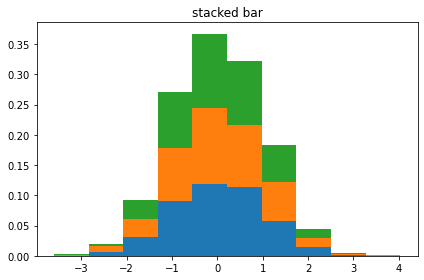

In [140]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(19680801)

n_bins = 10
x = np.random.randn(1000, 3)

fig, ((ax0)) = plt.subplots(nrows=1, ncols=1)

colors = ['red', 'tan', 'lime']

ax0.hist(x, n_bins, density=True, histtype='bar', stacked=True)
ax0.set_title('stacked bar')

fig.tight_layout()
plt.show()

In [142]:
x.shape

(1000, 3)

In [143]:
n_bins

10

In [144]:
x[:10]

array([[ 1.04930431,  0.86609917,  0.5511346 ],
       [ 1.72807779, -0.64928812, -0.47841958],
       [ 1.07788511,  0.96881033, -0.80934479],
       [-1.2373891 ,  1.86011654, -0.30831924],
       [ 0.78297055,  0.02152345,  0.71566379],
       [ 1.40146651, -1.12750212,  1.65581822],
       [ 1.40096148,  0.20199007, -0.96486356],
       [ 1.04458851, -0.43105069, -0.4973195 ],
       [-0.05911742, -1.11460467, -1.22699779],
       [-1.41008819,  1.31086051, -0.51744207]])